# 等离子体电子声不稳定性：Two-temperature Electrons Model

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import plasmapy.mathematics
import scipy.signal
import scipy.optimize as op
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

## 模型
### 1D等离子体：双温运动电子+静止均匀分布离子
- 初始分布函数
$$ f(x,v,0) = \left[ \frac{n_c}{\sqrt{2\pi T_c}} \exp{\left( -\frac{(v-u_c)^2}{2T_c} \right)} + \frac{n_h}{\sqrt{2\pi T_h}} \exp{\left( -\frac{(v-u_h)^2}{2T_h} \right)} \right] (1+d \cos kx) $$
             
- 色散关系（无漂移）
$$ \omega_{EAW}^2 = \omega_c^2 \frac{1+3k^2\lambda_c^2+3\lambda_c^2/\lambda_h^2}{1+1/(k^2\lambda_h^2)}$$
$$ \omega_{LW}^2  = \omega_p^2 \left[ 1+3k^2(\lambda_c^2+3\lambda_c^2) \frac{n_c n_h}{n^2} \right]$$

- 阻尼率（无漂移）：
$$ \gamma_{EAW} = -\sqrt{\frac{\pi}{8}} \frac{n_c}{n_h} k v_h \frac{1+3k^2\lambda_c^2+3\lambda_c^2/\lambda_h^2}{(1+k^2\lambda_h^2)^2}$$
$$ \gamma_{LW}  = -\sqrt{\frac{\pi}{8}} \omega_s\frac{1 + 3k^2 \lambda_s^2}{k^3 \lambda_s^3} \exp\left( -\frac{1}{2 k^2 \lambda_s^2} - \frac{3}{2} \right)$$

- 让EAW展现出来的关键在于
    - 排除热电子LW，$\gamma_{EAW} < \gamma_{LW}^{hot}$
    - EAW本身不能过阻尼，$\gamma_{EAW} \le \omega_r/(2\pi)$，满足此条件可获得存在较长时间的EAW
- 不稳定性：热电子漂移，冷电子不动
$$u_h = a v_c \qquad \text{and} \qquad u_c = 0$$

## 数值理论分析

In [341]:
def PDR_2TE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_c = (wc / k - u_c) /v_c
    zeta_h = (wc / k - u_h) /v_h
    r = 1 + 1 / k**2 / l_c**2 * ( 1 + zeta_c*plasmapy.mathematics.plasma_dispersion_func(zeta_c) ) + 1 / k**2 / l_h**2 * ( 1 + zeta_h*plasmapy.mathematics.plasma_dispersion_func(zeta_h) )
    return [r.real,r.imag]

def PDR_ANAL(k):
    klc = 1+3*k**2*l_c**2
    klh = 1+3*k**2*l_h**2

#     w_eaw = k*u_c + wp_c*np.sqrt(1/(1+1/(k*l_h)**2))
#     r_eaw = np.sqrt(np.pi/8) * wp_c/(k*l_h)**2 * (u_c-w_eaw/k)/v_h * np.exp(-(u_c-w_eaw/k)**2/2/v_h**2)
    w_eaw = wp_c*np.sqrt(klc/(1+1/(k*l_h)**2))
    r_eaw = -np.sqrt(np.pi/8) * n_c/n_h * (klc)/(1+k**2*l_h**2)**2 *k*np.sqrt(T_h)

    w_lw = wp*np.sqrt( 1 + 3 * k**2 * (l_c**2+l_h**2) * (n_c*n_h/n/n))
    r_lw= -np.sqrt(np.pi/8) * (wp_h/k**3/l_h**3) * klh * np.exp(-0.5/(k*l_h)**2-1.5)
    return w_eaw,r_eaw,w_lw,r_lw

def PrintParas():
    paras_table = PrettyTable(['a='+str(a),'n','T','wp','theta','lambda_D','u'])
    paras_table.add_row(['cool',n_c,T_c,round(wp_c,4),round(v_c,4),round(l_c,4),round(u_c,4)])
    paras_table.add_row(['hot ',n_h,T_h,round(wp_h,4),round(v_h,4),round(l_h,4),round(u_h,4)])
    print(paras_table)
    
def SetParas():
    n_h = n-n_c
    T_h = b*T_c
    wp_c = np.sqrt( n_c * q**2 )
    wp_h = np.sqrt( n_h * q**2 )
    l_c = np.sqrt(T_c/n_c)
    l_h = np.sqrt(T_h/n_h)
    v_c = np.sqrt(2*T_c/m)
    v_h = np.sqrt(2*T_h/m)
    u_c = 0
    u_h = a*v_c
    return n_h,T_h,wp_c,wp_h,l_c,l_h,v_c,v_h,u_c,u_h

In [342]:
# 等离子体基本参数
n = 1
q = 1
m = 1
n_c = 0.5
T_c = 0.01 #n*T/(nc+nh*b)
b = 100 #Th/Tc
a = 15
wp = np.sqrt(n*q**2)

n_h,T_h,wp_c,wp_h,l_c,l_h,v_c,v_h,u_c,u_h = SetParas()
PrintParas()

+------+-----+------+--------+--------+----------+--------+
| a=15 |  n  |  T   |   wp   | theta  | lambda_D |   u    |
+------+-----+------+--------+--------+----------+--------+
| cool | 0.5 | 0.01 | 0.7071 | 0.1414 |  0.1414  |   0    |
| hot  | 0.5 | 1.0  | 0.7071 | 1.4142 |  1.4142  | 2.1213 |
+------+-----+------+--------+--------+----------+--------+


- 计算不同a的初值

In [344]:
# 以色散关系的解析解做初值，求解精确0漂移的 w 和 r
k_list = np.linspace(0.1,2,num=101)
wr_eaw_guess,wi_eaw_guess,wr_lw_guess,wi_lw_guess = PDR_ANAL(k_start)

In [246]:
# 逐步增大a至目标，以前一个a的色散关系为初值计算下一个a
wr_eaw_list = []
wi_eaw_list = []
wr_lw_list = []
wi_lw_list = []
a_list = np.linspace(0,a,num=10*a+1)
for a_each in tqdm(a_list,position=0,leave=True):
    u_h = a_each * v_c
    s1 = op.root(lambda w:PDR_2TE(w,k_list[0]),[wr_eaw_guess,wi_eaw_guess])
    if s1.success==True:
        wr_eaw_guess = s1.x[0]
        wi_eaw_guess = s1.x[1]
        wr_eaw_list.append(s1.x[0])
        wi_eaw_list.append(s1.x[1])
        
    s_lw = op.root(lambda w:PDR_2TE(w,k_list[0]),[wr_lw_guess,wi_lw_guess])
    if s_lw.success==True:
        wr_lw_guess = s_lw.x[0]
        wi_lw_guess = s_lw.x[1]
        wr_lw_list.append(s_lw.x[0])
        wi_lw_list.append(s_lw.x[1])

wr_eaw_guess = wr_eaw_list[-1]
wi_eaw_guess = wi_eaw_list[-1]
wr_lw_guess = wr_lw_list[-1]
wi_lw_guess = wi_lw_list[-1]
print(len(wr_eaw_list)," - ",wr_eaw_list[-1])
print(len(wi_eaw_list)," - ",wi_eaw_list[-1])
print(len(wr_lw_list)," - ",wr_lw_list[-1])
print(len(wi_lw_list)," - ",wi_lw_list[-1])

100%|███████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 872.87it/s]

151  -  0.13210168563743574
151  -  0.05451777685182708
151  -  1.133687827014381
151  -  -1.012437898409051e-16


- 计算LW和EAW的$\omega$和$\gamma$

In [247]:
wr_eaw_list = []
wi_eaw_list = []
wr_lw_list = []
wi_lw_list = []
u_h = a*v_c
for k_each in tqdm(k_list,position=0,leave=True):
    s1=op.root(lambda w:PDR_2TE(w,k_each),[wr_eaw_guess,wi_eaw_guess])
    if s1.success==True:
        wr_eaw_guess = s1.x[0]
        wi_eaw_guess = s1.x[1]
        wr_eaw_list.append(s1.x[0])
        wi_eaw_list.append(s1.x[1])
        
    s3=op.root(lambda w:PDR_2TE(w,k_each),[wr_lw_guess,wi_lw_guess])
    if s3.success==True:
        wr_lw_guess = s3.x[0]
        wi_lw_guess = s3.x[1]
        wr_lw_list.append(s3.x[0])
        wi_lw_list.append(s3.x[1])

100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 716.32it/s]


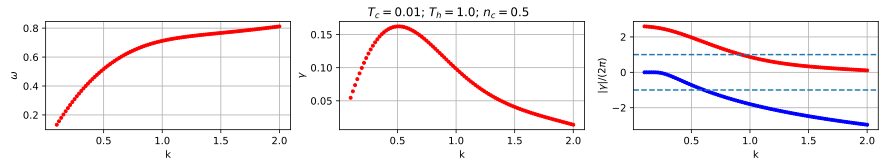

In [345]:
w_eaw_anal,r_eaw_anal,w_lw_anal,r_lw_anal = PDR_ANAL(k_list)
fig = plt.figure(figsize=(15,2))

ax1 = plt.subplot(131)
ax1.plot(k_list,wr_eaw_list,'.',color='red')
# ax1.plot(k_list,wr_lw_list,'.',color='blue')
# ax1.plot(k_list,w_eaw_anal,'--',color='red')
# ax1.plot(k_list,w_lw_anal,'--',color='blue')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$\omega$')
ax1.grid()

ax2 = plt.subplot(132)
ax2.plot(k_list,wi_eaw_list,'.',color='red')
# ax2.plot(k_list,wi_lw_list,'.',color='blue')
# ax2.plot(k_list,r_eaw_anal,'--',color='red')
# ax2.plot(k_list,r_lw_anal,'--',color='blue')
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\gamma$')
ax2.grid()

b_eaw = np.array(wi_eaw_list)/abs(np.array(wr_eaw_list)/2/np.pi)
b_lw = np.array(wi_lw_list)/abs(np.array(wr_lw_list)/2/np.pi)
ax3 = plt.subplot(133)
ax3.plot(k_list,b_eaw,'.',color='red')
ax3.plot(k_list,b_lw,'.',color='blue')
ax3.axhline(1,linestyle='--')
ax3.axhline(-1,linestyle='--')
ax3.set_xlabel('k')
ax3.set_ylabel(r'$|\gamma|/(2\pi)$')
ax3.grid()
plt.suptitle("$T_c = $"+str(T_c)+"; $T_h = $"+str(T_h)+"; $n_c = $"+str(n_c))
plt.show()

## 数值验证

### 模拟参数设定

In [364]:
k = 1.5
L = 2*np.pi/k

vmax = 6 # 速度最大值
nx = 1001
nv = 601
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
dt = 0.01
max_steps  = 12000
data_steps = 2000
data_num = int(max_steps/data_steps)+1
d = 0.001

path = '../data/'
print(data_num)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

7
limited time= 209.43951023931953
real time =  120.0


In [365]:
# 计算特定k的w,r
k_idx = int( (k-k_list[0])/(k_list[1]-k_list[0]) )
s1_k = op.root(lambda w:PDR_2TE(w,k),[wr_eaw_list[k_idx],wi_eaw_list[k_idx]])
s2_k = op.root(lambda w:PDR_2TE(w,k),[wr_lw_list[k_idx],wi_lw_list[k_idx]])
print(s1_k.success,s1_k.x)
print(s2_k.success,s2_k.x)
w_eaw = s1_k.x[0]
r_eaw = s1_k.x[1]
w_lw = s2_k.x[0]
r_lw = s2_k.x[1]

True [0.76684218 0.04069073]
True [ 5.52819835 -2.17998034]


### EAW条件检验
- $\gamma_{EAW} < \gamma_{LW}^{hot}$

In [366]:
print('r_eaw     = ',round(r_eaw,6))
print('r_lw = ',round(r_lw,6))

r_eaw     =  0.040691
r_lw =  -2.17998


- $k\lambda_h \le 1$

In [367]:
print('k*l_h = ',round(k*l_h,6))

k*l_h =  2.12132


- $\gamma_{EAW} < \omega_r/(2\pi)$

In [368]:
print('r_eaw   = ',round(r_eaw,6))
print('wr/2/pi = ',round(w_eaw/2/np.pi,6))

r_eaw   =  0.040691
wr/2/pi =  0.122047


## 模拟结果

In [369]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

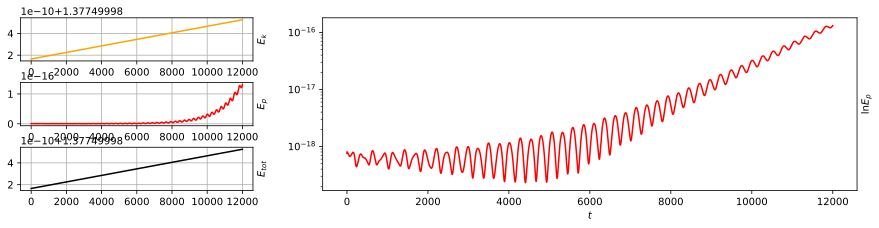

In [370]:
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

In [371]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [372]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L

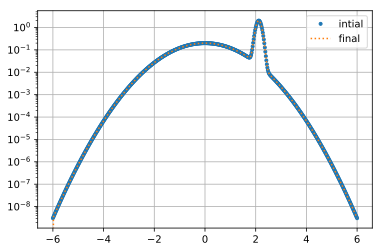

In [373]:
plt.plot(v,fv0,'.',label='intial')
plt.plot(v,fv,':',label='final')
# plt.plot(v,f_d(v),'--',label=r'Maxwellian')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [374]:
def PlotWaveFreq(t,y,refFreq,refFreq2):
    n = t.size
    y_k = fftpack.fft(y)
    x_k = fftpack.fftfreq(len(y_k),dt)
    y_k_abs = np.abs(y_k)
    y_k_phi = np.angle(y_k)

    plt.figure(figsize=(10,3))
    
    ax2 = plt.subplot()
    k_plot_scale=n//30
    ax2.plot(np.pi*x_k[1:k_plot_scale],2*y_k_abs[1:k_plot_scale]/n,color='black',lw=2)
    ax2.axvline(refFreq,color='red',ls='--',label=r'$\omega_1$ = '+str(round(refFreq,6)))
    ax2.axvline(refFreq2,color='orange',ls='--',label=r'$\omega_2$ = '+str(round(refFreq2,6)))
    ax2.set_title('freq-wave')
    ax2.set_xlabel(r'$\omega$')
    ax2.set_ylabel('A')
    ax2.grid()
    ax2.legend()
    
    plt.show()
    
def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs((a-b)/b)
    return r

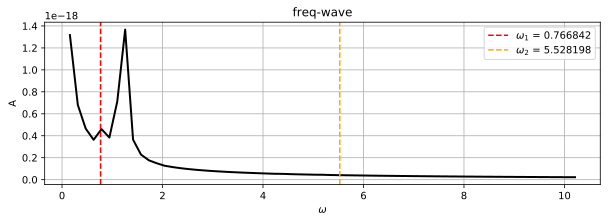

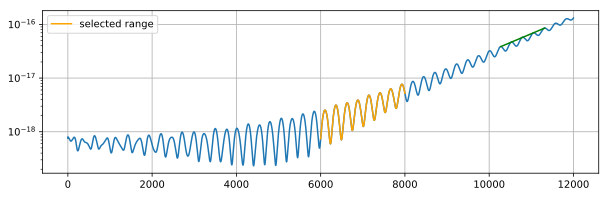

In [375]:
start = 6000
end = 8000

indexes, _ = scipy.signal.find_peaks(dataep, distance=5)
xep = indexes[40:45:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
wr_sim = 2*np.pi/per_sim/2
wi_sim = para[0]/dt/2

PlotWaveFreq(t[start:end],dataep[start:end],w_eaw,w_lw)
fig = plt.figure(figsize=(10,3))
plt.plot(t,dataep)
plt.plot(t[start:end],dataep[start:end],color='orange',label='selected range')
plt.plot(xep,np.exp(line(para,xep)), '-',color='green')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [376]:
wr_err = abs(wr_sim-w_eaw)/w_eaw*100
wi_err = abs(abs(wi_sim)-r_eaw)/abs(r_eaw)*100
com_table = PrettyTable(['EAW: k='+str(k),'wr','wi'])
com_table.add_row(['Theory',round(w_eaw,6),round(r_eaw,6)])
com_table.add_row(['Simulation',round(wr_sim,6),round(abs(wi_sim),6)])
com_table.add_row(['Error(%)',round(wr_err,6),round(abs(wi_err),6)])
print(com_table)

+------------+-----------+----------+
| EAW: k=1.5 |     wr    |    wi    |
+------------+-----------+----------+
|   Theory   |  0.766842 | 0.040691 |
| Simulation |  1.22241  | 0.038087 |
|  Error(%)  | 59.408236 | 6.399887 |
+------------+-----------+----------+
